<a href="https://colab.research.google.com/github/brenngraham/ml_exploration/blob/main/Image_Classification_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import the data

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 10s 0us/step


# Check the number of images

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


# Preview some images

Roses

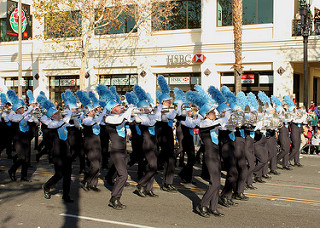

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

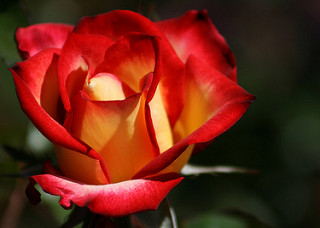

In [ ]:
PIL.Image.open(str(roses[1]))

Tulips

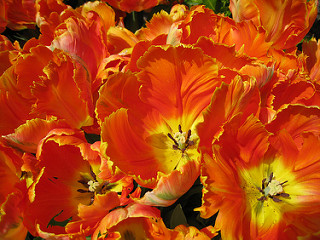

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

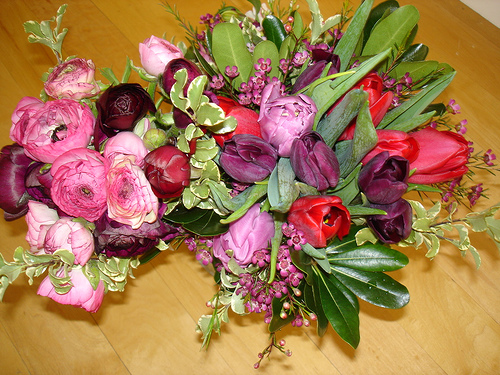

In [ ]:
PIL.Image.open(str(tulips[1]))

# Load images off the disk

In [ ]:
# Define some parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Load in the images, using 20% for the validation set

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Save and print the class names

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

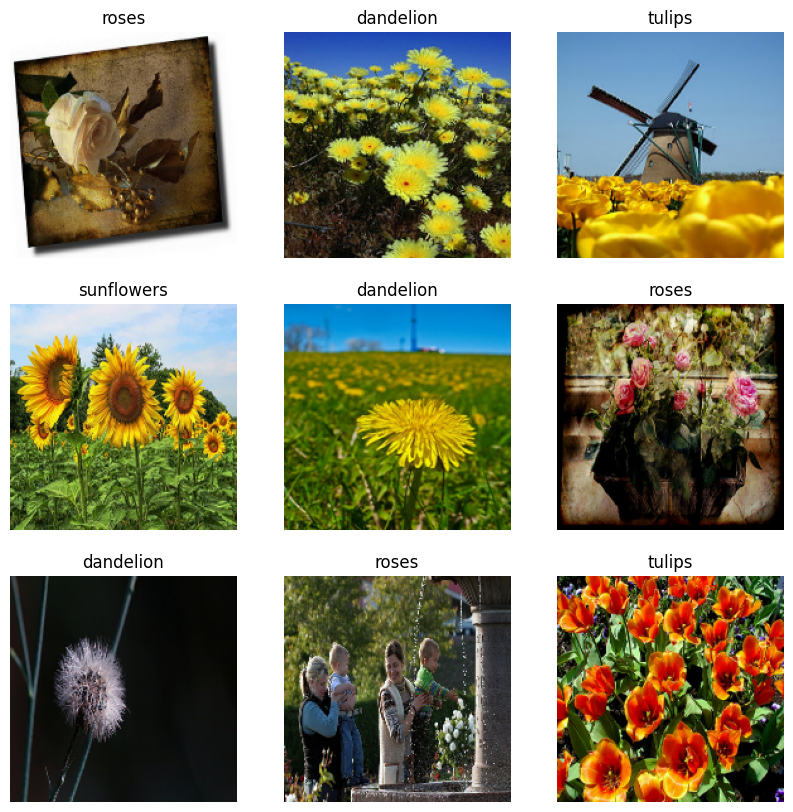

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Create the base model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model

In [ ]:
from keras.optimizers import Adam

# Define the Adam optimizer with a custom beta_1 value
custom_beta_1 = 0.9  # You can adjust this value based on your needs
adam_optimizer = Adam(learning_rate=0.001, beta_1=custom_beta_1)

model.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summarize the model

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_96 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_97 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_97 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_98 (Conv2D)          (None, 45, 45, 64)      

# Train the model

In [ ]:
epochs=11
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/11
92/92 [==============================] - 5s 24ms/step - loss: 1.3204 - accuracy: 0.4213 - val_loss: 1.1291 - val_accuracy: 0.5272
Epoch 2/11
92/92 [==============================] - 2s 22ms/step - loss: 1.0456 - accuracy: 0.5732 - val_loss: 0.9751 - val_accuracy: 0.6008
Epoch 3/11
92/92 [==============================] - 2s 21ms/step - loss: 0.8774 - accuracy: 0.6540 - val_loss: 0.9017 - val_accuracy: 0.6403
Epoch 4/11
92/92 [==============================] - 2s 24ms/step - loss: 0.7425 - accuracy: 0.7210 - val_loss: 0.8975 - val_accuracy: 0.6362
Epoch 5/11
92/92 [==============================] - 2s 24ms/step - loss: 0.5429 - accuracy: 0.7956 - val_loss: 0.8921 - val_accuracy: 0.6594
Epoch 6/11
92/92 [==============================] - 2s 22ms/step - loss: 0.3644 - accuracy: 0.8719 - val_loss: 0.9886 - val_accuracy: 0.6812
Epoch 7/11
92/92 [==============================] - 2s 21ms/step - loss: 0.2373 - accuracy: 0.9193 - val_loss: 1.0451 - val_accuracy: 0.6676
Epoch 8/11
92

# Visualize training results

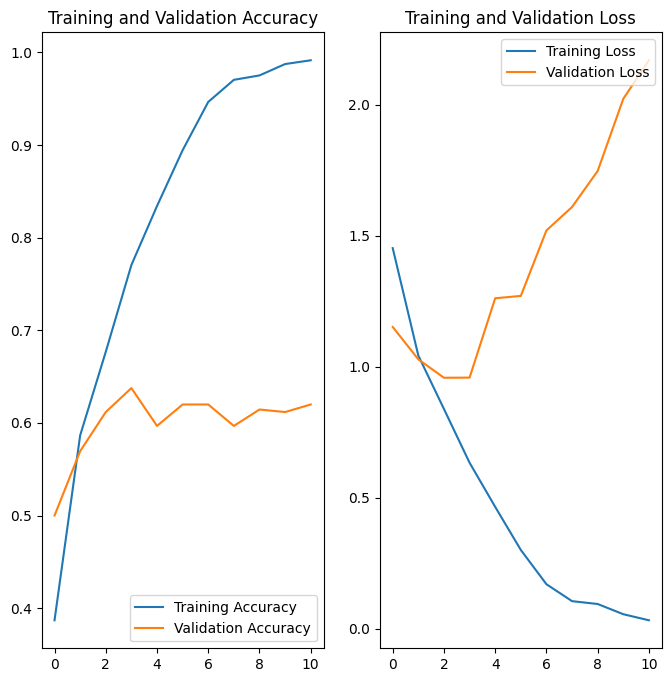

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Create the base model with double the channels

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 9s 54ms/step - loss: 1.2468 - accuracy: 0.4857 - val_loss: 1.1029 - val_accuracy: 0.5204
Epoch 2/10
92/92 [==============================] - 3s 36ms/step - loss: 0.9450 - accuracy: 0.6291 - val_loss: 0.9437 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 3s 38ms/step - loss: 0.7875 - accuracy: 0.7010 - val_loss: 0.8710 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 3s 38ms/step - loss: 0.5769 - accuracy: 0.7830 - val_loss: 0.9446 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 3s 37ms/step - loss: 0.3920 - accuracy: 0.8655 - val_loss: 1.0054 - val_accuracy: 0.6608
Epoch 6/10
92/92 [==============================] - 3s 36ms/step - loss: 0.2543 - accuracy: 0.9104 - val_loss: 1.0803 - val_accuracy: 0.6567
Epoch 7/10
92/92 [==============================] - 3s 38ms/step - loss: 0.0935 - accuracy: 0.9690 - val_loss: 1.4568 - val_accuracy: 0.6580
Epoch 8/10
92

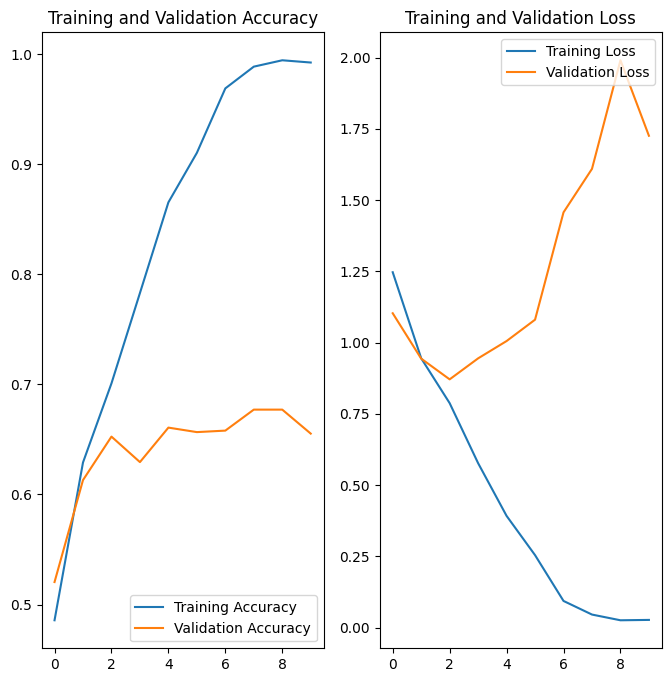

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Create the base model with more layers

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 5s 33ms/step - loss: 1.4128 - accuracy: 0.3631 - val_loss: 1.2853 - val_accuracy: 0.4210
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 1.2407 - accuracy: 0.4564 - val_loss: 1.1410 - val_accuracy: 0.5109
Epoch 3/10
92/92 [==============================] - 2s 26ms/step - loss: 1.0936 - accuracy: 0.5443 - val_loss: 1.0555 - val_accuracy: 0.5572
Epoch 4/10
92/92 [==============================] - 2s 26ms/step - loss: 0.9170 - accuracy: 0.6366 - val_loss: 1.0012 - val_accuracy: 0.5913
Epoch 5/10
92/92 [==============================] - 2s 26ms/step - loss: 0.8208 - accuracy: 0.6764 - val_loss: 0.8574 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 3s 28ms/step - loss: 0.7842 - accuracy: 0.6938 - val_loss: 0.7797 - val_accuracy: 0.6962
Epoch 7/10
92/92 [==============================] - 3s 28ms/step - loss: 0.7030 - accuracy: 0.7340 - val_loss: 0.8267 - val_accuracy: 0.6744
Epoch 8/10
92

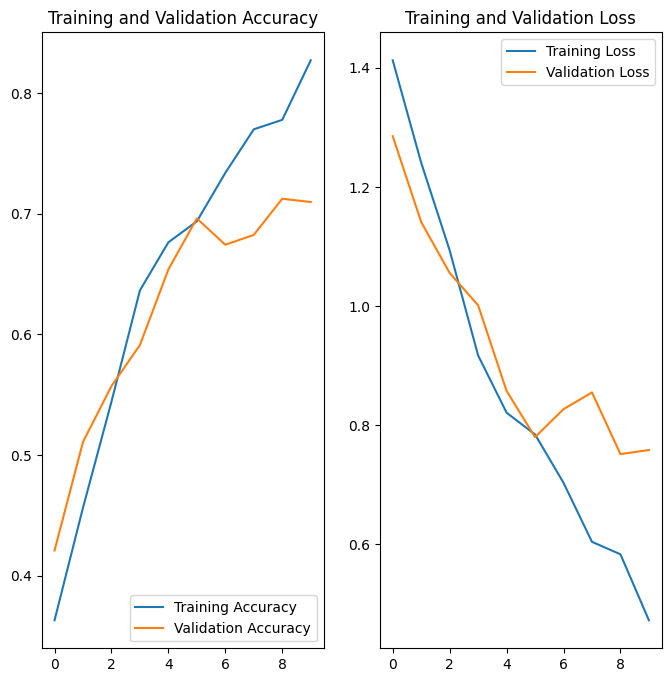

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Create the base model with more layers and double the channels

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 128)      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/13
92/92 [==============================] - 8s 56ms/step - loss: 1.3653 - accuracy: 0.3999 - val_loss: 1.0980 - val_accuracy: 0.5150
Epoch 2/13
92/92 [==============================] - 5s 57ms/step - loss: 1.1094 - accuracy: 0.5330 - val_loss: 1.1963 - val_accuracy: 0.4877
Epoch 3/13
92/92 [==============================] - 5s 55ms/step - loss: 1.0078 - accuracy: 0.5858 - val_loss: 0.9672 - val_accuracy: 0.6267
Epoch 4/13
92/92 [==============================] - 5s 56ms/step - loss: 0.8595 - accuracy: 0.6597 - val_loss: 0.7818 - val_accuracy: 0.6853
Epoch 5/13
92/92 [==============================] - 5s 58ms/step - loss: 0.7623 - accuracy: 0.7027 - val_loss: 0.7765 - val_accuracy: 0.6771
Epoch 6/13
92/92 [==============================] - 5s 55ms/step - loss: 0.7209 - accuracy: 0.7238 - val_loss: 0.8680 - val_accuracy: 0.6689
Epoch 7/13
92/92 [==============================] - 5s 56ms/step - loss: 0.6503 - accuracy: 0.7537 - val_loss: 0.7571 - val_accuracy: 0.7098
Epoch 8/13
92

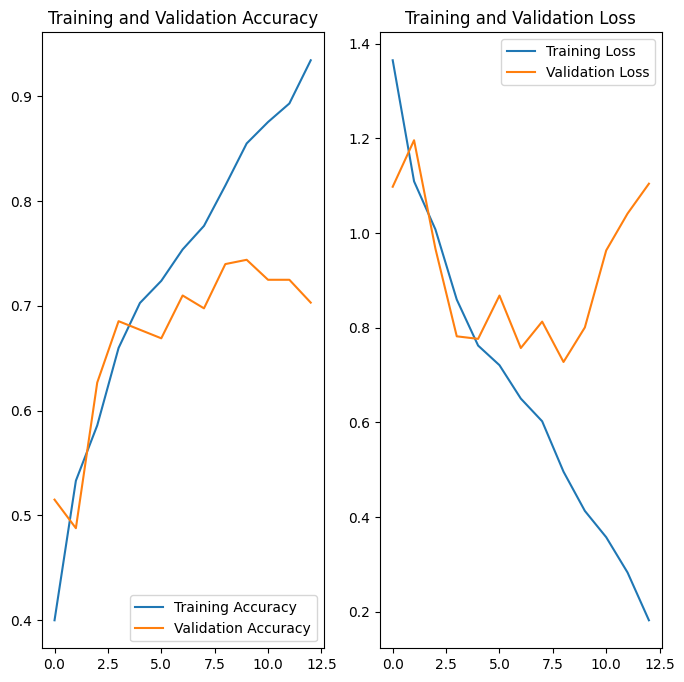

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using data augmentations (flip, rotation)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

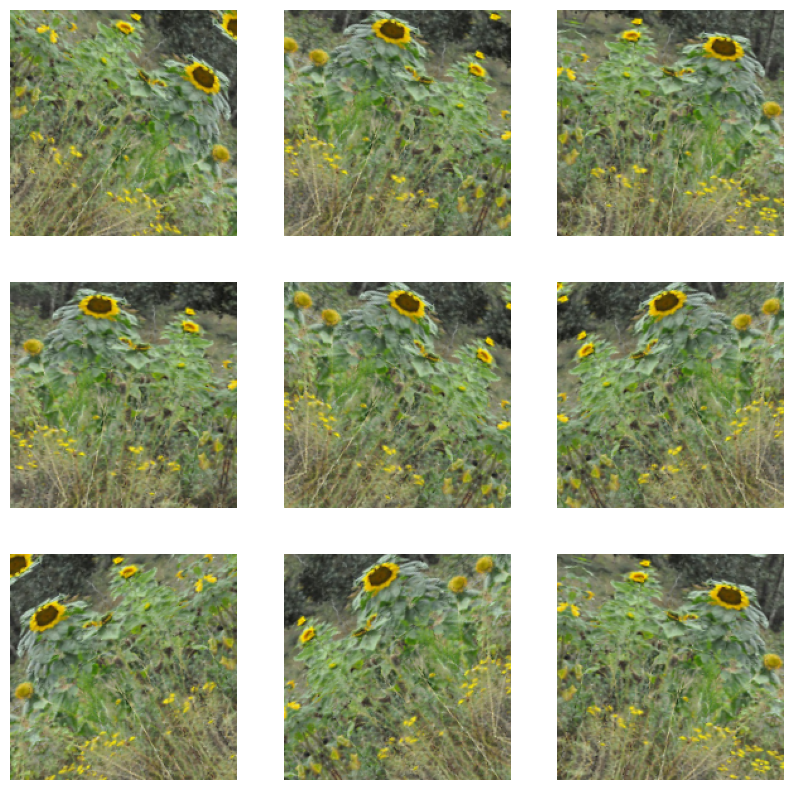

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 8s 58ms/step - loss: 1.5030 - accuracy: 0.3307 - val_loss: 1.3506 - val_accuracy: 0.3760
Epoch 2/20
92/92 [==============================] - 5s 57ms/step - loss: 1.3304 - accuracy: 0.3944 - val_loss: 1.3070 - val_accuracy: 0.3992
Epoch 3/20
92/92 [==============================] - 5s 55ms/step - loss: 1.2311 - accuracy: 0.4537 - val_loss: 1.1286 - val_accuracy: 0.5259
Epoch 4/20
92/92 [==============================] - 5s 59ms/step - loss: 1.1032 - accuracy: 0.5313 - val_loss: 1.0080 - val_accuracy: 0.5736
Epoch 5/20
92/92 [==============================] - 5s 57ms/step - loss: 1.0281 - accuracy: 0.5749 - val_loss: 1.0123 - val_accuracy: 0.5872
Epoch 6/20
92/92 [==============================] - 5s 56ms/step - loss: 0.9249 - accuracy: 0.6277 - val_loss: 0.8535 - val_accuracy: 0.6444
Epoch 7/20
92/92 [==============================] - 5s 57ms/step - loss: 0.8449 - accuracy: 0.6649 - val_loss: 0.8212 - val_accuracy: 0.6676
Epoch 8/20
92

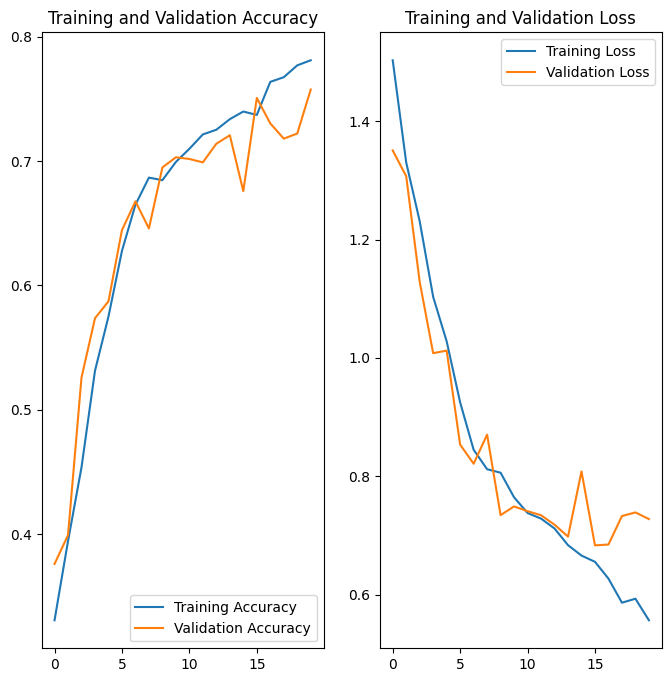

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# L2 Regularization

In [ ]:
from keras.regularizers import l2

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.0001)),
  layers.Dense(num_classes, kernel_regularizer=l2(0.0001))
])

NameError: ignored

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_156 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_156 (MaxPool  (None, 90, 90, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_157 (Conv2D)         (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_157 (MaxPool  (None, 45, 45, 64)        0         
 ing2D)                                              

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 8s 63ms/step - loss: 1.6228 - accuracy: 0.3181 - val_loss: 1.4002 - val_accuracy: 0.3706
Epoch 2/20
92/92 [==============================] - 5s 56ms/step - loss: 1.2574 - accuracy: 0.4745 - val_loss: 1.1248 - val_accuracy: 0.5477
Epoch 3/20
92/92 [==============================] - 5s 60ms/step - loss: 1.1221 - accuracy: 0.5487 - val_loss: 1.1179 - val_accuracy: 0.5572
Epoch 4/20
92/92 [==============================] - 5s 56ms/step - loss: 1.0571 - accuracy: 0.5725 - val_loss: 1.0444 - val_accuracy: 0.5708
Epoch 5/20
92/92 [==============================] - 5s 56ms/step - loss: 1.0160 - accuracy: 0.5913 - val_loss: 0.9940 - val_accuracy: 0.6131
Epoch 6/20
92/92 [==============================] - 5s 58ms/step - loss: 0.9327 - accuracy: 0.6328 - val_loss: 0.9326 - val_accuracy: 0.6308
Epoch 7/20
92/92 [==============================] - 5s 56ms/step - loss: 0.8834 - accuracy: 0.6621 - val_loss: 0.9638 - val_accuracy: 0.6117
Epoch 8/20
92

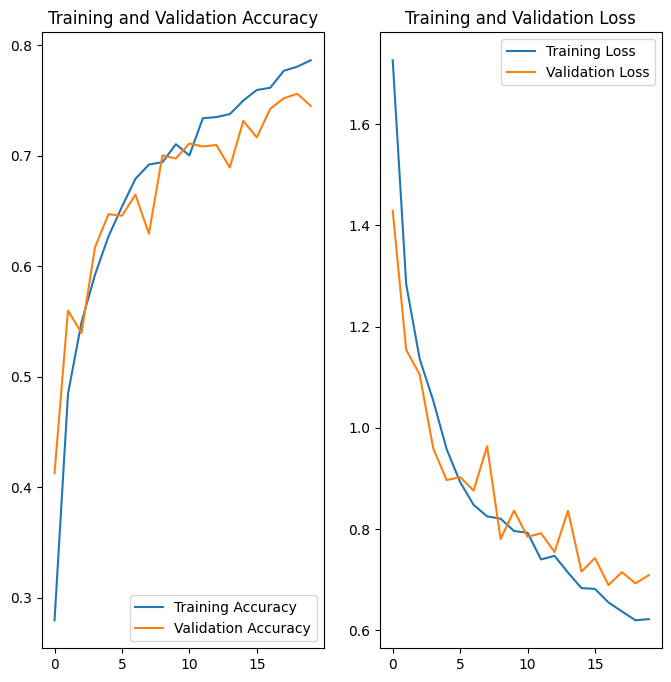

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Dropout rate tuning

In [ ]:
from keras.layers import Dropout

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  Dropout(0.25),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  Dropout(0.5),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

ValueError: ignored

In [ ]:
epochs= 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 79ms/step - loss: 1.5024 - accuracy: 0.3399 - val_loss: 1.4599 - val_accuracy: 0.3515
Epoch 2/15
92/92 [==============================] - 7s 80ms/step - loss: 1.2035 - accuracy: 0.4772 - val_loss: 1.1658 - val_accuracy: 0.4946
Epoch 3/15
92/92 [==============================] - 7s 76ms/step - loss: 1.0968 - accuracy: 0.5337 - val_loss: 1.1422 - val_accuracy: 0.5177
Epoch 4/15
92/92 [==============================] - 7s 78ms/step - loss: 1.0549 - accuracy: 0.5691 - val_loss: 1.1747 - val_accuracy: 0.4946
Epoch 5/15
92/92 [==============================] - 7s 74ms/step - loss: 0.9732 - accuracy: 0.6253 - val_loss: 0.9158 - val_accuracy: 0.6335
Epoch 6/15
92/92 [==============================] - 7s 75ms/step - loss: 0.9040 - accuracy: 0.6335 - val_loss: 0.8179 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 7s 74ms/step - loss: 0.8592 - accuracy: 0.6795 - val_loss: 1.0035 - val_accuracy: 0.6090
Epoch 8/15
9

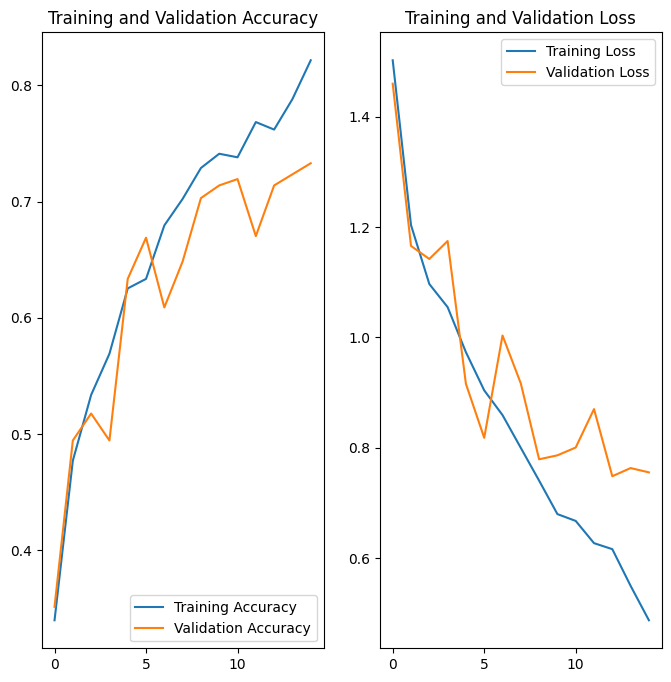

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()